## Modified MTGNN with VAE
The MTGNN model is modified to return the model state after the last layer. <br />
This feature space is used for input reconstruction with a Variational Autoencoder (VAE) <br />
and prediction of the next time step with a linear convolution network.<br />

The loss is the combination of the VAE and prediction losses: <br />

$L_{\theta, \Phi} = -\log (p_\theta(\mathbf{x})) + D_{KL}(q_\Phi(\mathbf{z\mid x})\parallel p_\theta(\mathbf{z\mid x}))$<br />

$L_{pred} = \frac{1}{n}\sum_{i=1}^n(\hat{Y_i}-Y_i)^2$<br />
<br />

#### Graph Learning
Graph learning is turned on by default. <br />
The model takes a new parameter *graph_type* determining the properties of the <br />
learned adjacency matrix. 

<pre>
graph_type='bi'  # creates an unstructured matrix for asymmetrical bi-directional graphs
graph_type='uni' # creates a skew-symmetrical matrix for uni-directional graphs (A = -A.T)
graph_type='sym' # creates a symmetrical matrix for undirected graphs (A = A.T)
</pre>
<br />




### MTGNN Modified

In [4]:
from __future__ import division

from typing import Optional

import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F


class Linear(nn.Module):
    r"""An implementation of the linear layer, conducting 2D convolution.
    For details see this paper: `"Connecting the Dots: Multivariate Time Series Forecasting with Graph Neural Networks."
    <https://arxiv.org/pdf/2005.11650.pdf>`_

    Args:
        c_in (int): Number of input channels.
        c_out (int): Number of output channels.
        bias (bool, optional): Whether to have bias. Default: True.
    """

    def __init__(self, c_in: int, c_out: int, bias: bool = True):
        super(Linear, self).__init__()
        self._mlp = torch.nn.Conv2d(
            c_in, c_out, kernel_size=(1, 1), padding=(0, 0), stride=(1, 1), bias=bias
        )

        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """
        Making a forward pass of the linear layer.

        Arg types:
            * **X** (Pytorch Float Tensor) - Input tensor, with shape (batch_size, c_in, num_nodes, seq_len).

        Return types:
            * **X** (PyTorch Float Tensor) - Output tensor, with shape (batch_size, c_out, num_nodes, seq_len).
        """
        return self._mlp(X)


class MixProp(nn.Module):
    r"""An implementation of the dynatic mix-hop propagation layer.
    For details see this paper: `"Connecting the Dots: Multivariate Time Series Forecasting with Graph Neural Networks."
    <https://arxiv.org/pdf/2005.11650.pdf>`_

    Args:
        c_in (int): Number of input channels.
        c_out (int): Number of output channels.
        gdep (int): Depth of graph convolution.
        dropout (float): Dropout rate.
        alpha (float): Ratio of retaining the root nodes's original states, a value between 0 and 1.
    """

    def __init__(self, c_in: int, c_out: int, gdep: int, dropout: float, alpha: float):
        super(MixProp, self).__init__()
        self._mlp = Linear((gdep + 1) * c_in, c_out)
        self._gdep = gdep
        self._dropout = dropout
        self._alpha = alpha

        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)

    def forward(self, X: torch.FloatTensor, A: torch.FloatTensor) -> torch.FloatTensor:
        """
        Making a forward pass of mix-hop propagation.

        Arg types:
            * **X** (Pytorch Float Tensor) - Input feature Tensor, with shape (batch_size, c_in, num_nodes, seq_len).
            * **A** (PyTorch Float Tensor) - Adjacency matrix, with shape (num_nodes, num_nodes).

        Return types:
            * **H_0** (PyTorch Float Tensor) - Hidden representation for all nodes, with shape (batch_size, c_out, num_nodes, seq_len).
        """
        A = A + torch.eye(A.size(0)).to(X.device)
        d = A.sum(1)
        H = X
        H_0 = X
        A = A / d.view(-1, 1)
        for _ in range(self._gdep):
            print(H.shape, A.shape)
            H = self._alpha * X + (1 - self._alpha) * torch.einsum(
                "ncwl,vw->ncvl", (H, A)
            )
            H_0 = torch.cat((H_0, H), dim=1)
        H_0 = self._mlp(H_0)
        return H_0


class DilatedInception(nn.Module):
    r"""An implementation of the dilated inception layer.
    For details see this paper: `"Connecting the Dots: Multivariate Time Series Forecasting with Graph Neural Networks."
    <https://arxiv.org/pdf/2005.11650.pdf>`_

    Args:
        c_in (int): Number of input channels.
        c_out (int): Number of output channels.
        kernel_set (list of int): List of kernel sizes.
        dilated_factor (int, optional): Dilation factor.
    """

    def __init__(self, c_in: int, c_out: int, kernel_set: list, dilation_factor: int):
        super(DilatedInception, self).__init__()
        self._time_conv = nn.ModuleList()
        self._kernel_set = kernel_set
        c_out = int(c_out / len(self._kernel_set))
        for kern in self._kernel_set:
            self._time_conv.append(
                nn.Conv2d(c_in, c_out, (1, kern), dilation=(1, dilation_factor))
            )
        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)

    def forward(self, X_in: torch.FloatTensor) -> torch.FloatTensor:
        """
        Making a forward pass of dilated inception.

        Arg types:
            * **X_in** (Pytorch Float Tensor) - Input feature Tensor, with shape (batch_size, c_in, num_nodes, seq_len).

        Return types:
            * **X** (PyTorch Float Tensor) - Hidden representation for all nodes,
            with shape (batch_size, c_out, num_nodes, seq_len-6).
        """
        X = []
        for i in range(len(self._kernel_set)):
            X.append(self._time_conv[i](X_in))
        for i in range(len(self._kernel_set)):
            X[i] = X[i][..., -X[-1].size(3) :]
        X = torch.cat(X, dim=1)
        return X


class GraphConstructor(nn.Module):
    r"""An implementation of the graph learning layer to construct an adjacency matrix.
    For details see this paper: `"Connecting the Dots: Multivariate Time Series Forecasting with Graph Neural Networks."
    <https://arxiv.org/pdf/2005.11650.pdf>`_

    Args:
        nnodes (int): Number of nodes in the graph.
        topk (int): Number of largest values to consider in constructing the neighbourhood of a node (pick the "nearest" k nodes).
        dim (int): Dimension of the node embedding.
        alpha (float, optional): Tanh alpha for generating adjacency matrix, alpha controls the saturation rate
        # xd (int, optional): Static feature dimension, default None.
    """

    def __init__(
        self, nnodes: int, topk: int, dim: int, alpha: float, type: Optional[str] = 'bi'
    ):
        super(GraphConstructor, self).__init__()
        
        self._embedding1 = nn.Embedding(nnodes, dim)
        self._embedding2 = nn.Embedding(nnodes, dim)
        self._linear1 = nn.Linear(dim, dim)
        self._linear2 = nn.Linear(dim, dim)

        self._nnodes = nnodes
        self._topk = topk
        self._alpha = alpha

        assert type in ['bi', 'uni', 'sym']
        self.graph_type = type

        self._A = None

        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)

    def get_A(self):
        if self._A is None:
            return self.forward()
        else:
            return self._A

    def forward(self) -> torch.FloatTensor:
        #self, idx: torch.LongTensor, FE: Optional[torch.FloatTensor] = None
    
        """
        Making a forward pass to construct an adjacency matrix from node embeddings.

        Arg types:
            # * **idx** (Pytorch Long Tensor) - Input indices, a permutation of the number of nodes, default None (no permutation).
            # * **FE** (Pytorch Float Tensor, optional) - Static feature, default None.
        Return types:
            * **A** (PyTorch Float Tensor) - Adjacency matrix constructed from node embeddings.
        """
        
        M1 = self._embedding1.weight.clone()
        M2 = self._embedding2.weight.clone()

        M1 = torch.tanh(self._alpha * self._linear1(M1))
        M2 = torch.tanh(self._alpha * self._linear2(M2))

        if self.graph_type is 'uni':

            a = torch.mm(M1, M2.transpose(1, 0)) - torch.mm(M2, M1.transpose(1, 0))

        elif self.graph_type is 'bi':
            a = torch.mm(M1, M2.transpose(1, 0)) 
            a.fill_diagonal_(0)

        elif self.graph_type is 'sym':
            a = torch.mm(M1, M1.transpose(1, 0)) - torch.mm(M2, M2.transpose(1, 0))
            a.fill_diagonal_(0)
        
        A = F.relu(torch.tanh(self._alpha * a))
        mask = torch.zeros(self._nnodes, self._nnodes).to(A.device)
        mask.fill_(float("0"))
        s1, t1 = A.topk(self._topk, 1)
        mask.scatter_(1, t1, s1.fill_(1))
        A = A * mask
        return A


class LayerNormalization(nn.Module):
    __constants__ = ["normalized_shape", "weight", "bias", "eps", "elementwise_affine"]
    r"""An implementation of the layer normalization layer.
    For details see this paper: `"Connecting the Dots: Multivariate Time Series Forecasting with Graph Neural Networks." 
    <https://arxiv.org/pdf/2005.11650.pdf>`_

    Args:
        normalized_shape (int): Input shape from an expected input of size.
        eps (float, optional): Value added to the denominator for numerical stability. Default: 1e-5.
        elementwise_affine (bool, optional): Whether to conduct elementwise affine transformation or not. Default: True.
    """

    def __init__(
        self, normalized_shape: int, eps: float = 1e-5, elementwise_affine: bool = True
    ):
        super(LayerNormalization, self).__init__()
        self._normalized_shape = tuple(normalized_shape)
        self._eps = eps
        self._elementwise_affine = elementwise_affine
        if self._elementwise_affine:
            self._weight = nn.Parameter(torch.Tensor(*normalized_shape))
            self._bias = nn.Parameter(torch.Tensor(*normalized_shape))
        else:
            self.register_parameter("_weight", None)
            self.register_parameter("_bias", None)
        self._reset_parameters()

    def _reset_parameters(self):
        if self._elementwise_affine:
            init.ones_(self._weight)
            init.zeros_(self._bias)

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """
        Making a forward pass of layer normalization.

        Arg types:
            * **X** (Pytorch Float Tensor) - Input tensor,
                with shape (batch_size, feature_dim, num_nodes, seq_len).
            * **idx** (Pytorch Long Tensor) - Input indices.

        Return types:
            * **X** (PyTorch Float Tensor) - Output tensor,
                with shape (batch_size, feature_dim, num_nodes, seq_len).
        """
        if self._elementwise_affine:
            return F.layer_norm(
                X,
                tuple(X.shape[1:]),
                self._weight,
                self._bias,
                self._eps,
            )
        else:
            return F.layer_norm(
                X, tuple(X.shape[1:]), self._weight, self._bias, self._eps
            )


class MTGNNLayer(nn.Module):
    r"""An implementation of the MTGNN layer.
    For details see this paper: `"Connecting the Dots: Multivariate Time Series Forecasting with Graph Neural Networks."
    <https://arxiv.org/pdf/2005.11650.pdf>`_

    Args:
        dilation_exponential (int): Dilation exponential.
        rf_size_i (int): Size of receptive field.
        kernel_size (int): Size of kernel for convolution, to calculate receptive field size.
        j (int): Iteration index.
        residual_channels (int): Residual channels.
        conv_channels (int): Convolution channels.
        skip_channels (int): Skip channels.
        kernel_set (list of int): List of kernel sizes.
        new_dilation (int): Dilation.
        layer_norm_affline (bool): Whether to do elementwise affine in Layer Normalization.
        # gcn_true (bool): Whether to add graph convolution layer.
        seq_length (int): Length of input sequence.
        receptive_field (int): Receptive field.
        dropout (float): Droupout rate.
        gcn_depth (int): Graph convolution depth.
        num_nodes (int): Number of nodes in the graph.
        propalpha (float): Prop alpha, ratio of retaining the root nodes's original states in mix-hop propagation, a value between 0 and 1.

    """

    def __init__(
        self,
        dilation_exponential: int,
        rf_size_i: int,
        kernel_size: int,
        j: int,
        residual_channels: int,
        conv_channels: int,
        skip_channels: int,
        kernel_set: list,
        new_dilation: int,
        layer_norm_affline: bool,
        # gcn_true: bool,
        seq_length: int,
        receptive_field: int,
        dropout: float,
        gcn_depth: int,
        num_nodes: int,
        propalpha: float,
    ):
        super(MTGNNLayer, self).__init__()
        self._dropout = dropout
        # self._gcn_true = gcn_true

        if dilation_exponential > 1:
            rf_size_j = int(
                rf_size_i
                + (kernel_size - 1)
                * (dilation_exponential ** j - 1)
                / (dilation_exponential - 1)
            )
        else:
            rf_size_j = rf_size_i + j * (kernel_size - 1)

        self._filter_conv = DilatedInception(
            residual_channels,
            conv_channels,
            kernel_set=kernel_set,
            dilation_factor=new_dilation,
        )

        self._gate_conv = DilatedInception(
            residual_channels,
            conv_channels,
            kernel_set=kernel_set,
            dilation_factor=new_dilation,
        )
             
        if seq_length > receptive_field:
            self._skip_conv = nn.Conv2d(
                in_channels=conv_channels,
                out_channels=skip_channels,
                kernel_size=(1, seq_length - rf_size_j + 1),
            )
        else:
            self._skip_conv = nn.Conv2d(
                in_channels=conv_channels,
                out_channels=skip_channels,
                kernel_size=(1, receptive_field - rf_size_j + 1),
            )

        # if gcn_true:
        self._mixprop_conv1 = MixProp(
            conv_channels, residual_channels, gcn_depth, dropout, propalpha
        )

        self._mixprop_conv2 = MixProp(
            conv_channels, residual_channels, gcn_depth, dropout, propalpha
        )

        if seq_length > receptive_field:
            self._normalization = LayerNormalization(
                (residual_channels, num_nodes, seq_length - rf_size_j + 1),
                elementwise_affine=layer_norm_affline,
            )

        else:
            self._normalization = LayerNormalization(
                (residual_channels, num_nodes, receptive_field - rf_size_j + 1),
                elementwise_affine=layer_norm_affline,
            )
        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)

    def forward(
        self,
        X: torch.FloatTensor,
        X_skip: torch.FloatTensor,
        A_tilde: Optional[torch.FloatTensor],
        # idx: torch.LongTensor,
        training: bool,
    ) -> torch.FloatTensor:
        """
        Making a forward pass of MTGNN layer.

        Arg types:
            * **X** (PyTorch FloatTensor) - Input feature tensor,
                with shape (batch_size, in_dim, num_nodes, seq_len).
            * **X_skip** (PyTorch FloatTensor) - Input feature tensor for skip connection,
                with shape (batch_size, in_dim, num_nodes, seq_len).
            * **A_tilde** (Pytorch FloatTensor or None) - Predefined adjacency matrix.
            # * **idx** (Pytorch LongTensor) - Input indices.
            * **training** (bool) - Whether in traning mode.

        Return types:
            * **X** (PyTorch FloatTensor) - Output sequence tensor,
                with shape (batch_size, seq_len, num_nodes, seq_len).
            * **X_skip** (PyTorch FloatTensor) - Output feature tensor for skip connection,
                with shape (batch_size, in_dim, num_nodes, seq_len).
        """
        X_residual = X
        X_filter = self._filter_conv(X)
        X_filter = torch.tanh(X_filter)
        X_gate = self._gate_conv(X)
        X_gate = torch.sigmoid(X_gate)
        X = X_filter * X_gate
        
        X = F.dropout(X, self._dropout, training=training)
        X_skip = self._skip_conv(X) + X_skip
        X = self._mixprop_conv1(X, A_tilde) + self._mixprop_conv2(
            X, A_tilde.transpose(1, 0)
        )
        X = X + X_residual[:, :, :, -X.size(3) :]

        X = self._normalization(X)
        return X, X_skip


class MTGNN(nn.Module):
    r"""An implementation of the Multivariate Time Series Forecasting Graph Neural Networks.
    For details see this paper: `"Connecting the Dots: Multivariate Time Series Forecasting with Graph Neural Networks."
    <https://arxiv.org/pdf/2005.11650.pdf>`_

    Args:
        # gcn_true (bool): Whether to add graph convolution layer.
        # build_adj (bool): Whether to construct adaptive adjacency matrix.
        gcn_depth (int): Graph convolution depth.
        num_nodes (int): Number of nodes in the graph.
        kernel_set (list of int): List of kernel sizes.
        kernel_size (int): Size of kernel for convolution, to calculate receptive field size.
        dropout (float): Droupout rate.
        topk (int): Size of subgraph.
        node_embedding_dim (int): Dimension of nodes.
        dilation_exponential (int): Dilation exponential.
        conv_channels (int): Convolution channels.
        residual_channels (int): Residual channels.
        skip_channels (int): Skip channels.
        out_channels (int): End channels.
        seq_length (int): Length of input sequence.
        in_dim (int): Input dimension.
        # out_dim (int): Output dimension.
        layers (int): Number of layers.
        propalpha (float): Prop alpha, ratio of retaining the root nodes's original states in mix-hop propagation, a value between 0 and 1.
        tanhalpha (float): Tanh alpha for generating adjacency matrix, alpha controls the saturation rate.
        layer_norm_affline (bool): Whether to do elementwise affine in Layer Normalization.
        # xd (int, optional): Static feature dimension, default None.
    """

    def __init__(
        self,
        gcn_depth: int,
        num_nodes: int,
        kernel_set: list,
        kernel_size: int,
        dropout: float,
        topk: int,
        node_embedding_dim: int,
        dilation_exponential: int,
        conv_channels: int,
        residual_channels: int,
        skip_channels: int,
        out_channels: int,
        seq_length: int,
        in_dim: int,
        layers: int,
        propalpha: float,
        tanhalpha: float,
        layer_norm_affline: bool,
        graph_type: Optional[str] = 'bi',
    ):
        super(MTGNN, self).__init__()

        self._num_nodes = num_nodes
        self._dropout = dropout
        self._seq_length = seq_length
        self._layers = layers

        self._mtgnn_layers = nn.ModuleList()

        self._graph_constructor = GraphConstructor(
            num_nodes, topk, node_embedding_dim, alpha=tanhalpha, type=graph_type
        )

        self._set_receptive_field(dilation_exponential, kernel_size, layers)

        new_dilation = 1
        for j in range(1, layers + 1):
            self._mtgnn_layers.append(
                MTGNNLayer(
                    dilation_exponential=dilation_exponential,
                    rf_size_i=1,
                    kernel_size=kernel_size,
                    j=j,
                    residual_channels=residual_channels,
                    conv_channels=conv_channels,
                    skip_channels=skip_channels,
                    kernel_set=kernel_set,
                    new_dilation=new_dilation,
                    layer_norm_affline=layer_norm_affline,
                    seq_length=seq_length,
                    receptive_field=self._receptive_field,
                    dropout=dropout,
                    gcn_depth=gcn_depth,
                    num_nodes=num_nodes,
                    propalpha=propalpha,
                )
            )

            new_dilation *= dilation_exponential

        self._setup_conv(in_dim, skip_channels, out_channels, residual_channels)

        self._reset_parameters()

    def _setup_conv(self, in_dim, skip_channels, out_channels, residual_channels):

        self._start_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=residual_channels, kernel_size=(1, 1)
        )

        if self._seq_length > self._receptive_field:

            self._skip_conv_0 = nn.Conv2d(
                in_channels=in_dim,
                out_channels=skip_channels,
                kernel_size=(1, self._seq_length),
                bias=True,
            )

            self._skip_conv_E = nn.Conv2d(
                in_channels=residual_channels,
                out_channels=skip_channels,
                kernel_size=(1, self._seq_length - self._receptive_field + 1),
                bias=True,
            )

        else:
            self._skip_conv_0 = nn.Conv2d(
                in_channels=in_dim,
                out_channels=skip_channels,
                kernel_size=(1, self._receptive_field),
                bias=True,
            )

            self._skip_conv_E = nn.Conv2d(
                in_channels=residual_channels,
                out_channels=skip_channels,
                kernel_size=(1, 1),
                bias=True,
            )

        self._out_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=skip_channels,
                out_channels=out_channels,
                kernel_size=(1, 1),
                bias=True,
            ),
            nn.BatchNorm2d(out_channels),
        )


    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)

    def _set_receptive_field(self, dilation_exponential, kernel_size, layers):
        if dilation_exponential > 1:
            self._receptive_field = int(
                1
                + (kernel_size - 1)
                * (dilation_exponential ** layers - 1)
                / (dilation_exponential - 1)
            )
        else:
            self._receptive_field = layers * (kernel_size - 1) + 1

    def get_adjacency_matrix(self):
        return self._graph_constructor.get_A()

    def forward(self, X_in: torch.FloatTensor) -> torch.FloatTensor:
        """
        Making a forward pass of MTGNN.

        Arg types:
            * **X_in** (PyTorch FloatTensor) - Input sequence, with shape (batch_size, in_dim, num_nodes, seq_len).
            # * **A_tilde** (Pytorch FloatTensor, optional) - Predefined adjacency matrix, default None.
            # * **idx** (Pytorch LongTensor, optional) - Input indices, a permutation of the num_nodes, default None (no permutation).
            # * **FE** (Pytorch FloatTensor, optional) - Static feature, default None.

        Return types:
            * **X** (PyTorch FloatTensor) - Output sequence for prediction, with shape (batch_size, seq_len, num_nodes, 1).
        """
        seq_len = X_in.size(3)
        assert (seq_len == self._seq_length), "Input sequence length not equal to preset sequence length."

        if self._seq_length < self._receptive_field:
            X_in = F.pad(
                X_in, (self._receptive_field - self._seq_length, 0, 0, 0)
            )

        A_tilde = self._graph_constructor()
                
        X = self._start_conv(X_in)
        X_skip = self._skip_conv_0(
            F.dropout(X_in, self._dropout, training=self.training)
        )
        
        for mtgnn in self._mtgnn_layers:
            X, X_skip = mtgnn(X, X_skip, A_tilde, self.training)     
        
        X_skip = F.relu(self._skip_conv_E(X) + X_skip)
        
        return F.leaky_relu(self._out_conv(X_skip))


### MTGNN VAE+Pred

100%|██████████| 500/500 [05:21<00:00,  1.55it/s]


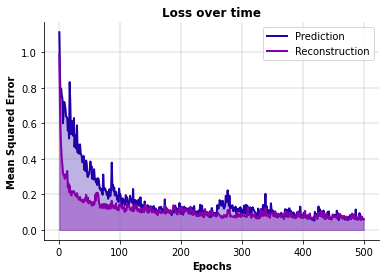

Train MSE: Prediction: 0.0601 - Reconstruction: 0.0602
Test MSE: Prediction: 0.8477 - Reconstruction: 0.0552


In [39]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

from torch_geometric.data import DataLoader

loader = ChickenpoxDatasetLoader()

lags = 10
stride = 1
epochs = 500
batch_size = 32

dataset = loader.get_dataset(lags)

sample = next(iter(dataset))
num_nodes = sample.x.size(0)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

train_loader = DataLoader(list(train_dataset), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(test_dataset), batch_size=batch_size, shuffle=False)

### MODEL DEFINITION
class GNN_VAE(nn.Module):
    def __init__(self):
        super(GNN_VAE, self).__init__()

        out_channels = 32
        latent_dim = 32

        self.gnn = MTGNN(
            gcn_depth=3,
            num_nodes=num_nodes,
            kernel_set=[5,5,5],
            kernel_size=5,
            dropout=0.2,
            topk=5,
            node_embedding_dim=64,
            dilation_exponential=2,
            conv_channels=30,
            residual_channels=32,
            skip_channels=32,
            out_channels=out_channels,
            seq_length=lags,
            in_dim=1,
            layers=2,
            propalpha=0.2,
            tanhalpha=0.5,
            layer_norm_affline=True,
            graph_type='bi'
        )

        self.prediction = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=64,
                kernel_size=(1, 1),
                bias=True,
            ), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(1, 1),
                bias=True,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,
                out_channels=1,
                kernel_size=(1, 1),
                bias=True,
            )
        )

        self.vae_encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=128,
                kernel_size=(1, 1),
                bias=True,
            ), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,
                out_channels=64,
                kernel_size=(1, 1),
                bias=True,
            ), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=2*latent_dim,
                kernel_size=(1, 1),
                bias=True,
            )
        )

        self.vae_decoder = nn.Sequential(
                nn.Conv2d(
                    in_channels=latent_dim,
                    out_channels=64,
                    kernel_size=(1, 1),
                    bias=True,
                ),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(
                    in_channels=64,
                    out_channels=128,
                    kernel_size=(1, 1),
                    bias=True,
                ),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(
                    in_channels=128,
                    out_channels=2*lags,
                    kernel_size=(1, 1),
                    bias=True,
                )
            )
        self.bn = nn.BatchNorm2d(lags)


    def forward(self, x):
        # (batch, 1, num_nodes, lags)
        x = x.permute(0,3,2,1)
        x = self.bn(x)
        x = x.permute(0,3,2,1)

        B, _, N, T = x.shape     
        h = self.gnn(x) # (batch, out_channels, num_nodes, 1)
        # print(x.shape)
        
        mu_z, logvar_z = self.vae_encoder(h).chunk(2, dim=1)
        std_z = torch.exp(0.5 * logvar_z)
        kld = torch.mean(-0.5 * torch.mean(1 + logvar_z - (mu_z ** 2) - logvar_z.exp(), dim = 1))

        eps = torch.rand_like(std_z)
        K = 5
        z = torch.stack([std_z * eps + mu_z for _ in range(K)], dim=0)
        K, B, C, N, _ = z.shape
        z = z.view(K*B, C, N, -1)
        
        mu_x, logvar_x = self.vae_decoder(z).permute(0,3,2,1).contiguous().view(K,B,1,N,2*T).chunk(2, dim=4)
        
        y_hat = self.prediction(h).squeeze(-1).permute(0,2,1).flatten()      

        return y_hat, mu_x, logvar_x, kld
    
model = GNN_VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
kld_weight = 1

### TRAIN
model.train()

pred_loss_history = []
rec_loss_history = []
for _ in tqdm(range(epochs)):
    total_pred_loss = 0
    total_rec_loss = 0
    for i, window in enumerate(train_loader):
        x = window.x.view(-1, 1, num_nodes, lags)
        y = window.y

        optimizer.zero_grad()
        
        y_pred, mu_x, logvar_x, kld = model(x)

        log_likelihood = -((x.unsqueeze(0) - mu_x) ** 2) / (2 * torch.exp(logvar_x)) - logvar_x - math.log(math.sqrt(2 * math.pi))
               
        assert y_pred.shape == y.shape

        pred_loss = torch.mean((y_pred - y)**2)
        vae_loss = kld_weight * kld - log_likelihood.mean()

        loss = pred_loss + vae_loss

        total_pred_loss += pred_loss.item()
        total_rec_loss += torch.mean((mu_x - x)**2).item()

        loss.backward()
        optimizer.step()

    total_rec_loss /= i+1
    total_pred_loss /= i+1

    pred_loss_history.append(total_pred_loss)
    rec_loss_history.append(total_rec_loss)

### TEST 
model.eval()
pred_loss = 0
rec_loss = 0
with torch.no_grad():
    for i, window in enumerate(test_loader):
        x = window.x.view(-1, 1, num_nodes, lags)
        y = window.y

        y_pred, mu_x, logvar_x, kld = model(x)

        log_likelihood = -((x - mu_x) ** 2) / (2 * torch.exp(logvar_x)) - logvar_x - math.log(math.sqrt(2 * math.pi))
        
        assert y_pred.shape == y.shape

        pred_loss += torch.mean((y_pred - y)**2).item()
        rec_loss += torch.mean((mu_x - x)**2).item()
        
    pred_loss /= i+1
    rec_loss /= i+1

### RESULTS PLOT
colors = ['#2300a8', '#8400a8'] # '#8400a8', '#00A658'
plot_dict = {'Prediction': (pred_loss_history, colors[0]), 'Reconstruction': (rec_loss_history, colors[1])}

n = len(pred_loss_history)

# plot train and val losses and log_likelihood area under the curve
fig, ax = plt.subplots()
x_axis = list(range(1, n+1))
for key, (data, color) in plot_dict.items():
    ax.plot(x_axis, data, 
                label=key, 
                linewidth=2, 
                linestyle='-', 
                alpha=1, 
                color=color)
    ax.fill_between(x_axis, data, 
                alpha=0.3, 
                color=color)

# figure labels
ax.set_title('Loss over time', fontweight='bold')
ax.set_xlabel('Epochs', fontweight='bold')
ax.set_ylabel('Mean Squared Error', fontweight='bold')
ax.legend(loc='upper right')

# remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# adds major gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.35, alpha=0.8)

# y-axis in log scale (reconstruction loss tends to start high)
# ax.set_yscale('log')
plt.show()

print("Train MSE: Prediction: {:.4f} - Reconstruction: {:.4f}".format(pred_loss_history[-1], rec_loss_history[-1]))
print("Test MSE: Prediction: {:.4f} - Reconstruction: {:.4f}".format(pred_loss, rec_loss))


### Learned Graph

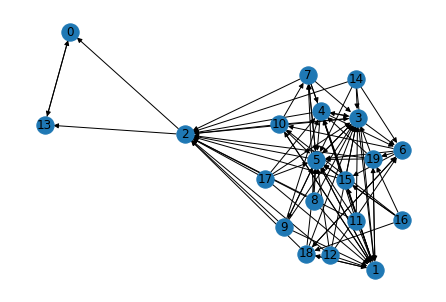

In [40]:
import networkx as nx

A = model.gnn.get_adjacency_matrix()
G = nx.from_numpy_matrix(np.matrix(A.detach()), create_using=nx.DiGraph)

layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels = True)
plt.show()

### True Graph

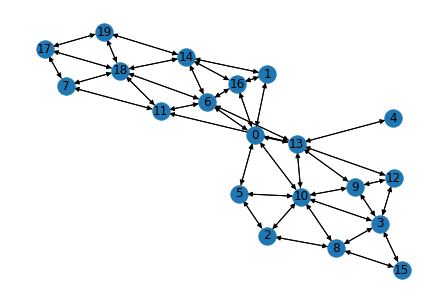

In [41]:
edge_indices = dataset.edge_index
edge_list = zip(*edge_indices)
edge_list = [(a,b) for a,b in edge_list if not a == b] # remove self loops

# generate graph from edge list
G = nx.from_edgelist(edge_list, create_using=nx.DiGraph)

layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels = True)
plt.show()